### Train NNs on the toy example

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
import dama as dm
import pickle
import os

from freedom.toy_model import toy_model
from types import SimpleNamespace
from toy_NN_trafo import build_q_trafo, build_h_trafo

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
toy_experiment = toy_model.toy_experiment(detector_xs = np.linspace(-5, 5, 5), t_std=1)

In [334]:
toy_experiment.detector_xs

array([-5. , -2.5,  0. ,  2.5,  5. ])

In [338]:
example_x_src = 1.
example_b_src = 1.
example_N_src = 10

In [339]:
# generate one test event
test_event = toy_experiment.generate_event(x_src=example_x_src, b=example_b_src, N_src=example_N_src)

In [340]:
test_event

(array([[ 0. , -5. ,  0. ],
        [ 0. , -2.5,  1. ],
        [ 4. ,  0. ,  2. ],
        [ 3. ,  2.5,  3. ],
        [ 0. ,  5. ,  4. ]]),
 array([[4.77198587, 0.        , 2.        ],
        [2.76144176, 0.        , 2.        ],
        [6.61009841, 0.        , 2.        ],
        [4.08009202, 0.        , 2.        ],
        [6.25543048, 2.5       , 3.        ],
        [5.18728121, 2.5       , 3.        ],
        [4.85452975, 2.5       , 3.        ]]))

In [341]:
%%time
# Grid scan

g = dm.GridData(x=np.linspace(-5, 5, 100), b=np.linspace(0, 2, 100))

g['dom_hit_term'] = np.empty(g.shape)
g['dom_charge_terms'] = np.empty(g.shape)
g['total_charge_hit_terms'] = np.empty(g.shape)
g['total_charge_terms'] = np.empty(g.shape)

for idx in np.ndindex(g.shape):
    hypo_x =  g['x'][idx]
    hypo_b =  g['b'][idx]
    hypo_t = 0
    hypo_N_src = example_N_src
    g['dom_hit_term'][idx] = -toy_experiment.dom_hit_term(test_event[1], hypo_x, hypo_b, 0)
    g['dom_charge_terms'][idx] = -toy_experiment.dom_charge_term(test_event[0], hypo_x, hypo_b, hypo_N_src)
    g['total_charge_hit_terms'][idx] = -toy_experiment.total_charge_hit_term(test_event[1], hypo_x, hypo_b, hypo_t, hypo_N_src)
    g['total_charge_terms'][idx] = -toy_experiment.total_charge_term(test_event[0], hypo_x, hypo_b, hypo_N_src)

CPU times: user 5.28 s, sys: 0 ns, total: 5.28 s
Wall time: 5.28 s


In [342]:
g['dom_hit_term'] -= g['dom_hit_term'].min()
g['dom_charge_terms'] -= g['dom_charge_terms'].min()
g['dom_llh'] = g['dom_hit_term'] + g['dom_charge_terms']
g['total_charge_hit_terms'] -= g['total_charge_hit_terms'].min()
g['total_charge_terms'] -= g['total_charge_terms'].min()
g['total_charge_llh'] = g['total_charge_hit_terms'] + g['total_charge_terms']

g['dom_llh'] -= g['dom_llh'].min()
g['total_charge_llh'] -= g['total_charge_llh'].min()

In [343]:
g['dom_hit_term'] > 0

b \ x,-5,-4.9,-4.8,...,4.8,4.9,5
0,True,True,True,...,True,True,True
0.0202,True,True,True,...,True,True,True
0.0404,True,True,True,...,True,True,True
...,...,...,...,...,...,...,...
1.96,True,True,True,...,True,True,True
1.98,True,True,True,...,True,True,True
2,True,True,True,...,True,True,True


In [344]:
def plot_truth(axes, x, y):
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    for ax in axes.flatten():
        ax.plot([x], [y], marker='$T$', markersize=10, color='k')

In [345]:
def plot_diff(a, b, axes, title_a='a', title_b='b', vmax=None, limit_diff=False, **kwargs):
    
    levels = stats.chi2(df=2).isf(stats.norm.sf(np.arange(1,6))*2)/2    
    labels = [str(i) + r'$\sigma$' for i in range(1,6)]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    colors = plt.cm.viridis(np.linspace(0, 0.9, 6))
    a.plot(ax=axes[0], cmap='Greys', label=r'$\Delta LLH$', **kwargs)
    a.plot_contour(ax=axes[0], levels=levels, labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
    axes[0].set_title(title_a)
    b.plot(ax=axes[1], cmap='Greys', label=r'$\Delta LLH$', **kwargs)
    b.plot_contour(ax=axes[1], levels=levels,  labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
    axes[1].set_title(title_b)
    diff = a - b
    if limit_diff:
        diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-vmax, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
        #diff.plot_contour(ax=axes[2], levels=levels, labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
        #np.clip(-diff, 0, None).plot_contour(ax=axes[2], levels=[0.1,0.2, 0.3], colors=['r']*2)
    else:
        diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), label=r'$\Delta LLH$', **kwargs) 
        #diff.plot_contour(ax=axes[2], levels=levels, labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
    axes[2].set_title('diff')

In [346]:
#stats.norm.isf(stats.chi2(df=2).sf(g['dom_llh']*2)/2)

/home/iwsatlas1/peller/dama/dama/plotting/stat_plot.py:494: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax.contour(X, Y, data, **kwargs)


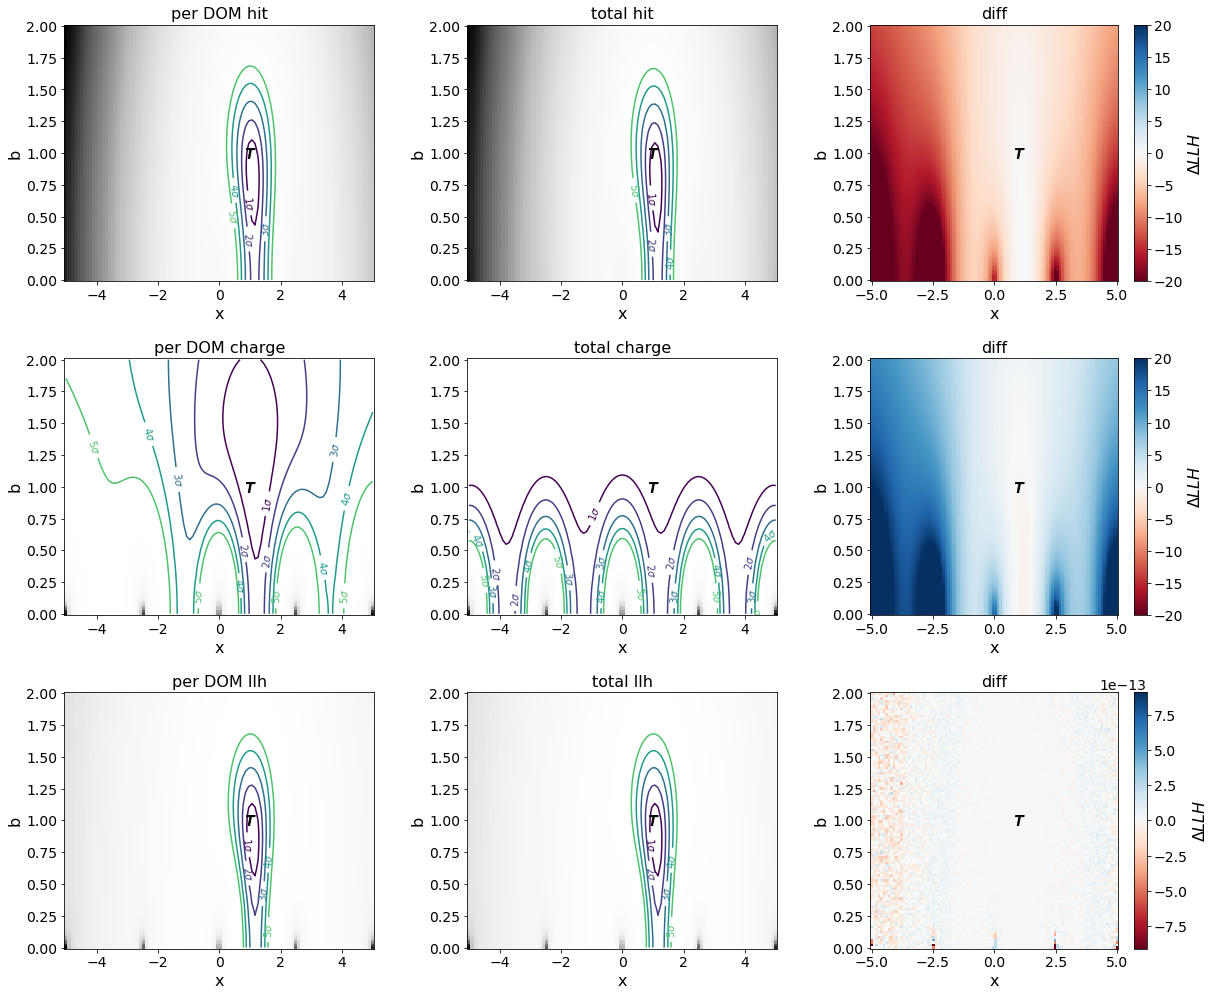

In [347]:
fig, ax = plt.subplots(3, 3, figsize=(20,17))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plot_diff(g['dom_hit_term'], g['total_charge_hit_terms'], axes=ax[0], title_a='per DOM hit', title_b='total hit', vmax=20, limit_diff=True)
plot_diff(g['dom_charge_terms'], g['total_charge_terms'], axes=ax[1], title_a='per DOM charge', title_b='total charge', vmax=20, limit_diff=True)
plot_diff(g['dom_llh'], g['total_charge_llh'], axes=ax[2], title_a='per DOM llh', title_b='total llh', limit_diff=False)

plot_truth(ax, example_x_src, example_b_src)

In [269]:
np.max(np.abs(g['dom_llh'] - g['total_charge_llh']))

4.547473508864641e-13

In [271]:
stats.chi2(df=2).isf(stats.norm.sf(np.arange(1,6))*2)/2

array([ 1.14787446,  3.09003715,  5.91457904,  9.66695431, 14.37185121])

# Train NNs

In [106]:
#!rm events.pkl

In [107]:
%%time
fname = 'toy_mc_sim_events_more_evts_paper.pkl'
if os.path.isfile(fname):
    with open(fname, 'rb') as file:
        events = pickle.load(file)
else:
    events = toy_experiment.generate_events(int(1e5), N_lims=(0, 20))
    with open(fname, 'wb') as file:
        pickle.dump(events, file, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 272 ms, sys: 56.8 ms, total: 329 ms
Wall time: 328 ms


In [14]:
mc, truth = events

In [15]:
hitnet = SimpleNamespace()
chargenet = SimpleNamespace()

Prepare Data for NN

In [16]:
mc[0][0]

array([[ 1. , -5. ,  0. ],
       [ 3. , -2.5,  1. ],
       [ 1. ,  0. ,  2. ],
       [ 0. ,  2.5,  3. ],
       [ 0. ,  5. ,  4. ]])

In [17]:
chargenet.x = []
hitnet.x = []
for item in mc:
    chargenet.x.append(item[1].shape[0])
    hitnet.x.append(item[1])

In [18]:
chargenet.x = np.array(chargenet.x)[:, np.newaxis]
hitnet.x = np.concatenate(hitnet.x)

In [19]:
chargenet.t = np.copy(truth)
hitnet.t = np.repeat(truth, chargenet.x[:, 0], axis=0)

In [20]:
assert chargenet.x.shape[0] == chargenet.t.shape[0]
assert hitnet.x.shape[0] == hitnet.t.shape[0]

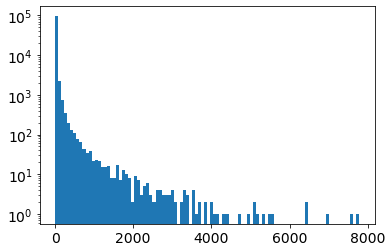

In [21]:
plt.hist(chargenet.x[:,0], bins=100)
plt.gca().set_yscale('log')

In [22]:
def get_dataset(x, t, shuffle_block_size=2**15, batch_size=2**12, test=False):
        '''
        get a tensorflow dataset for likelihood approximation
        
        Parameters:
        -----------
        x : ndarray
            observations
        t : ndarray
            parameters        
        shuffle_block_size : int
            block size over which to shuffle, should be multiple of batch_size
        batch_size : int
        test : bool
            no shuffling, prefetching and caching
        
        Returns:
        --------
        
        tf.data.Dataset
            with structure ((x, t), y) for training
        
        '''
        
        N = x.shape[0]
        assert t.shape[0] == N
        
        d_x = tf.data.Dataset.from_tensor_slices(x)
        d_t = tf.data.Dataset.from_tensor_slices(t)

        d_true_labels = tf.data.Dataset.from_tensor_slices(np.ones((N, 1), dtype=x.dtype))
        d_false_labels = tf.data.Dataset.from_tensor_slices(np.zeros((N, 1), dtype=x.dtype))

        d_xs = tf.data.Dataset.from_tensor_slices([d_x, d_x]).interleave(lambda x : x)
        d_ts = tf.data.Dataset.from_tensor_slices([d_t, d_t.shuffle(shuffle_block_size)]).interleave(lambda x : x)
        d_ys = tf.data.Dataset.from_tensor_slices([d_true_labels, d_false_labels]).interleave(lambda x : x)
        
        
        dataset = tf.data.Dataset.zip((tf.data.Dataset.zip((d_xs, d_ts)), d_ys))
  
        if not test:
            dataset = dataset.shuffle(shuffle_block_size)

        return dataset.batch(batch_size)

## chargenet

In [23]:
chargenet.x_train, chargenet.x_test, chargenet.t_train, chargenet.t_test = train_test_split(chargenet.x, chargenet.t, test_size=0.2, random_state=42)

In [24]:
chargenet.d_train = get_dataset(chargenet.x_train, chargenet.t_train)
chargenet.d_test = get_dataset(chargenet.x_test, chargenet.t_test, test=True)

2022-02-08 14:50:09.367839: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [25]:
det_xs = toy_experiment.detector_xs
chargenet.trafo = build_q_trafo(det_xs)

In [26]:
activation='relu'

x_input = tf.keras.Input(shape=(chargenet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(chargenet.t_train.shape[1],))

h = chargenet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

# h = tf.keras.layers.Dense(32, activation=activation)(h)

# h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

chargenet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
chargenet.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 q_trafo (q_trafo)              (None, 5)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 32)           192         ['q_trafo[0][0]']            

In [27]:
optimizer = tf.keras.optimizers.Adam(0.0005)
chargenet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [28]:
chargenet.hist = chargenet.model.fit(chargenet.d_train, epochs=30, verbose=1, validation_data=chargenet.d_test)

Epoch 1/30
40/40 [==============================] - 3s 61ms/step - loss: 0.7834 - val_loss: 0.6490
Epoch 2/30
40/40 [==============================] - 2s 52ms/step - loss: 0.6331 - val_loss: 0.6103
Epoch 3/30
40/40 [==============================] - 2s 51ms/step - loss: 0.5891 - val_loss: 0.5611
Epoch 4/30
40/40 [==============================] - 2s 51ms/step - loss: 0.5479 - val_loss: 0.5221
Epoch 5/30
40/40 [==============================] - 2s 52ms/step - loss: 0.5140 - val_loss: 0.4930
Epoch 6/30
40/40 [==============================] - 2s 52ms/step - loss: 0.4871 - val_loss: 0.4741
Epoch 7/30
40/40 [==============================] - 2s 53ms/step - loss: 0.4735 - val_loss: 0.4622
Epoch 8/30
40/40 [==============================] - 2s 53ms/step - loss: 0.4557 - val_loss: 0.4446
Epoch 9/30
40/40 [==============================] - 2s 52ms/step - loss: 0.4391 - val_loss: 0.4276
Epoch 10/30
40/40 [==============================] - 2s 52ms/step - loss: 0.4304 - val_loss: 0.4223
Epoch 11/

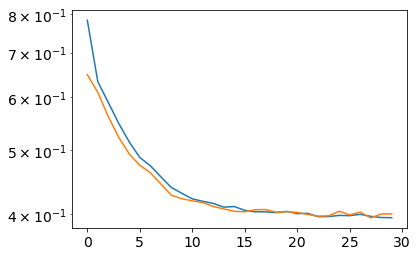

In [29]:
plt.plot(chargenet.model.history.history['loss'])
plt.plot(chargenet.model.history.history['val_loss'])
plt.gca().set_yscale('log')

In [30]:
chargenet.llh = tf.keras.models.clone_model(chargenet.model)
chargenet.llh.set_weights(chargenet.model.get_weights())
chargenet.llh.layers[-1].activation = tf.keras.activations.linear
chargenet.llh.compile()

In [348]:
chargenet.tts = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T
chargenet.xxs = np.repeat(len(test_event[0]), np.prod(g.shape), axis=0)
chargenet.xxs = chargenet.xxs.reshape(-1, 1)

In [349]:
chargenet.llhs = chargenet.llh.predict([chargenet.xxs, chargenet.tts])    

In [350]:
g['charge_llh'] = -np.sum(chargenet.llhs.reshape(-1, 1), axis=1).reshape(g.shape)
g['charge_llh'] -= np.min(g['charge_llh'])

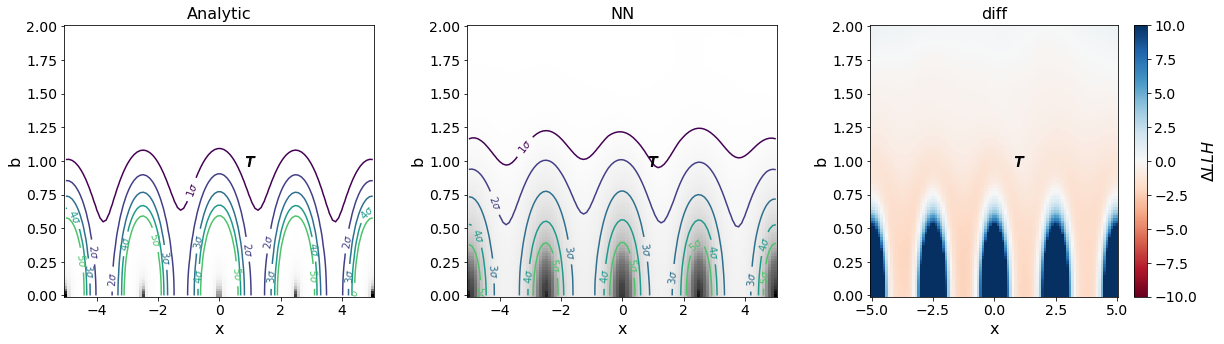

In [351]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g['total_charge_terms'], g['charge_llh'], title_a='Analytic', title_b='NN', vmax=10, axes=ax, limit_diff=True)
plot_truth(ax, example_x_src, example_b_src)

## hitnet

In [35]:
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.x, hitnet.t, test_size=0.2, random_state=42)

In [36]:
hitnet.d_train = get_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = get_dataset(hitnet.x_test, hitnet.t_test, test=True)

In [37]:
hitnet.trafo = build_h_trafo(det_xs)

In [38]:
activation='elu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 h_trafo (h_trafo)              (None, 8)            0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 32)           288         ['h_trafo[0][0]']          

In [39]:
optimizer = tf.keras.optimizers.Adam(0.0005)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [40]:
hist = hitnet.model.fit(hitnet.d_train, epochs=10, verbose=1, validation_data=hitnet.d_test)

Epoch 1/10
1028/1028 [==============================] - 58s 56ms/step - loss: 0.2563 - val_loss: 0.2348
Epoch 2/10
1028/1028 [==============================] - 58s 56ms/step - loss: 0.2301 - val_loss: 0.2287
Epoch 3/10
1028/1028 [==============================] - 57s 56ms/step - loss: 0.2272 - val_loss: 0.2264
Epoch 4/10
1028/1028 [==============================] - 58s 56ms/step - loss: 0.2257 - val_loss: 0.2258
Epoch 5/10
1028/1028 [==============================] - 58s 56ms/step - loss: 0.2250 - val_loss: 0.2244
Epoch 6/10
1028/1028 [==============================] - 58s 56ms/step - loss: 0.2248 - val_loss: 0.2232
Epoch 7/10
1028/1028 [==============================] - 58s 56ms/step - loss: 0.2236 - val_loss: 0.2237
Epoch 8/10
1028/1028 [==============================] - 58s 56ms/step - loss: 0.2237 - val_loss: 0.2237
Epoch 9/10
1028/1028 [==============================] - 58s 56ms/step - loss: 0.2233 - val_loss: 0.2230
Epoch 10/10
1028/1028 [==============================] - 58s 56m

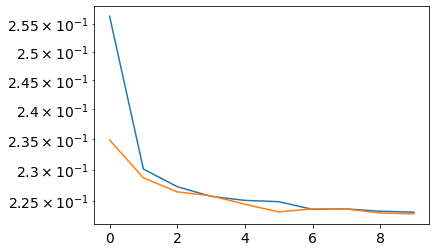

In [41]:
plt.plot(hitnet.model.history.history['loss'])
plt.plot(hitnet.model.history.history['val_loss'])
plt.gca().set_yscale('log')

In [42]:
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

In [352]:
hitnet.tt = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T
hitnet.tts = np.repeat(hitnet.tt, test_event[1].shape[0], axis=0)
hitnet.xxs = np.repeat(test_event[1][np.newaxis,:, :], np.prod(g.shape), axis=0)
hitnet.xxs = hitnet.xxs.reshape(-1, 3)

In [353]:
hitnet.llhs = hitnet.llh.predict([hitnet.xxs, hitnet.tts])    

In [354]:
g['hit_llh'] = -np.sum(hitnet.llhs.reshape(-1, test_event[1].shape[0]), axis=1).reshape(g.shape)
g['hit_llh'] -= np.min(g['hit_llh'])

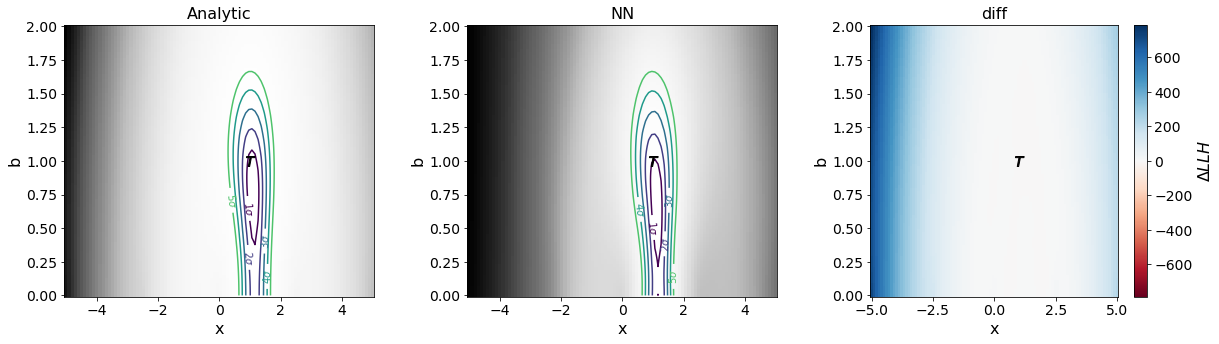

In [355]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g['total_charge_hit_terms'], g['hit_llh'], title_a='Analytic', title_b='NN', 
          vmax=50, axes=ax, limit_diff=False)
plot_truth(ax, example_x_src, example_b_src)

In [357]:
g['llh'] = g['charge_llh'] + g['hit_llh']
g['llh'] -= np.min(g['llh'])

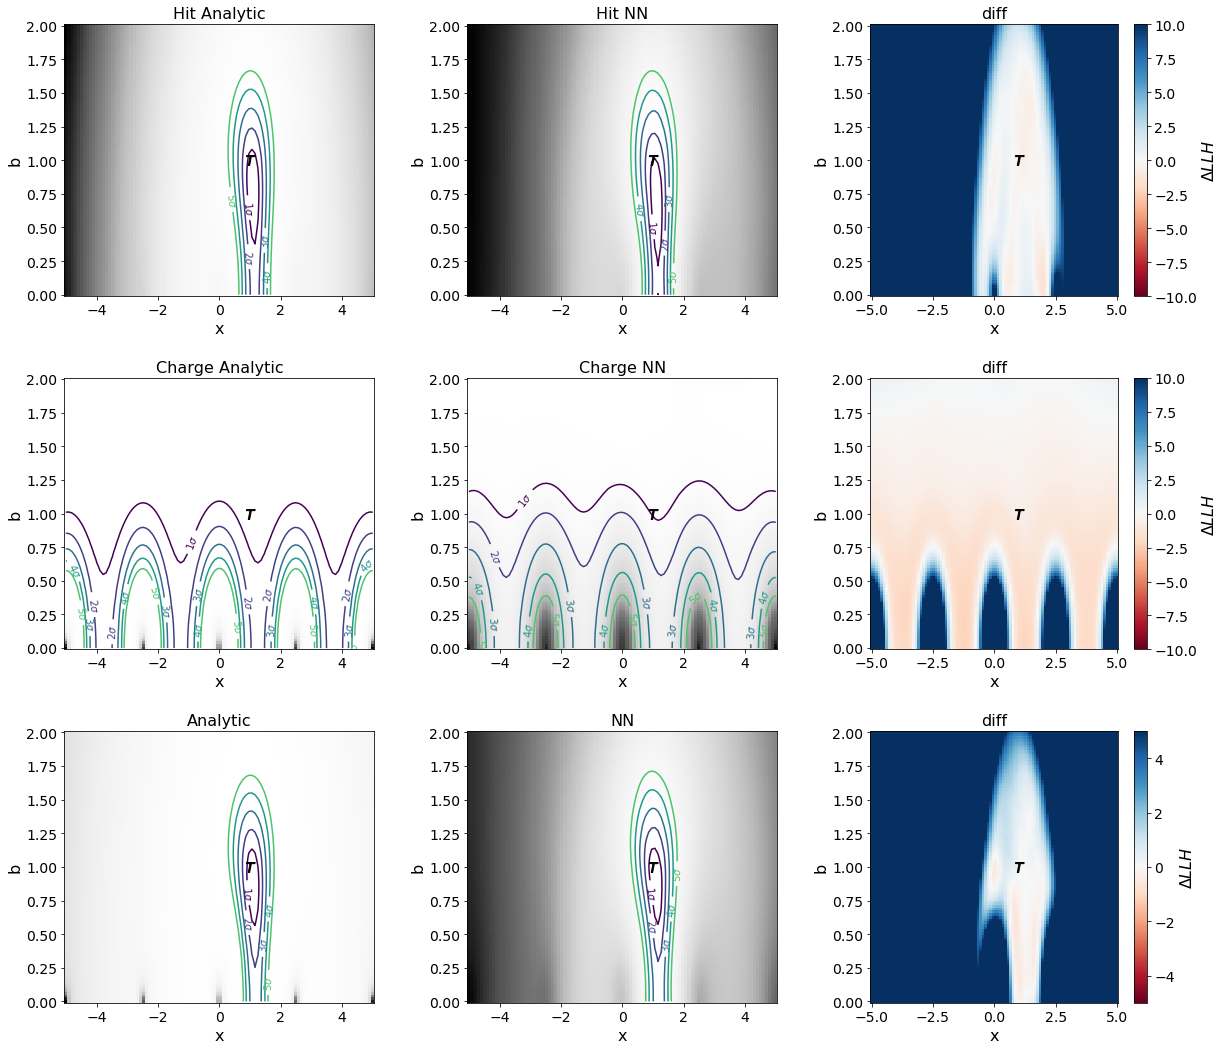

In [359]:
fig, ax = plt.subplots(3, 3, figsize=(20,18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Zoom in
#grid_to_plot = g[example_x_src-0.5:example_x_src+0.5, example_b_src-0.5:example_b_src+0.5]

grid_to_plot = g

plot_diff(grid_to_plot['total_charge_hit_terms'], grid_to_plot['hit_llh'], 
          title_a='Hit Analytic', title_b='Hit NN', vmax=10, axes=ax[0], limit_diff=True)
plot_diff(grid_to_plot['total_charge_terms'], grid_to_plot['charge_llh'], 
          title_a='Charge Analytic', title_b='Charge NN', vmax=10, axes=ax[1], limit_diff=True)
plot_diff(grid_to_plot['total_charge_llh'], grid_to_plot['llh'], title_a='Analytic',
          title_b='NN', vmax=5, axes=ax[2], limit_diff=True)

plot_truth(ax, example_x_src, example_b_src)

#plt.savefig('NNtest.png', bbox_inches='tight')

### Save the models now

In [49]:
chargenet.model.save('paper_toy_chargenet.h5')

In [50]:
#chargenet = tf.keras.models.load_model('paper_toy_chargenet.h5', custom_objects=dict(q_trafo=build_q_trafo(toy_experiment.detector_xs)))
#hitnet = tf.keras.models.load_model('paper_toy_hitnet.h5', custom_objects=dict(h_trafo=build_h_trafo(toy_experiment.detector_xs)))

In [51]:
hitnet.model.save('paper_toy_hitnet.h5')

(0.0, 100.0)

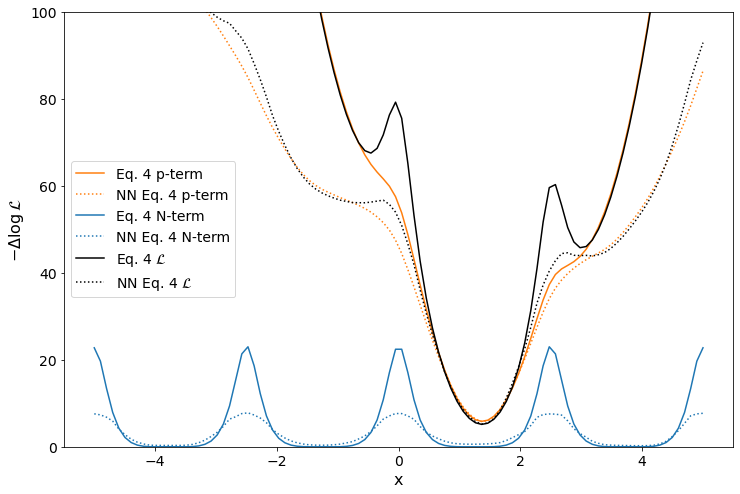

In [112]:
s = g[:,0.3]
#s = g[1.45]

fig, ax = plt.subplots(1,1, figsize=(12,8))

c2 = 'tab:blue'
c1 = 'tab:orange'
c3 = 'k' #tab:green'


#s.dom_hit_term.plot(c=c3, ls=':', label="Eq. 2 p-term")
#s.dom_charge_terms.plot(c=c3, ls='--', label="Eq. 2 N-term")
#s.dom_llh.plot(c=c3, label=r"Eq. 2 $\mathcal{L}$")


s.total_charge_hit_terms.plot(c=c1, ls='-', label="Eq. 4 p-term")
s.hit_llh.plot(c=c1, ls=':', label="NN Eq. 4 p-term")

s.total_charge_terms.plot(c=c2, ls='-', label="Eq. 4 N-term")
s.charge_llh.plot(c=c2, ls=':', label="NN Eq. 4 N-term")

s.total_charge_llh.plot(c=c3, ls='-', label=r"Eq. 4 $\mathcal{L}$")
s.llh.plot(c=c3, ls=':', label=r"NN Eq. 4 $\mathcal{L}$")


plt.legend()

ax.set_ylabel(r'$-\Delta\log{\mathcal{L}}$')

plt.gca().set_ylim(0, 100)

(0.0, 100.0)

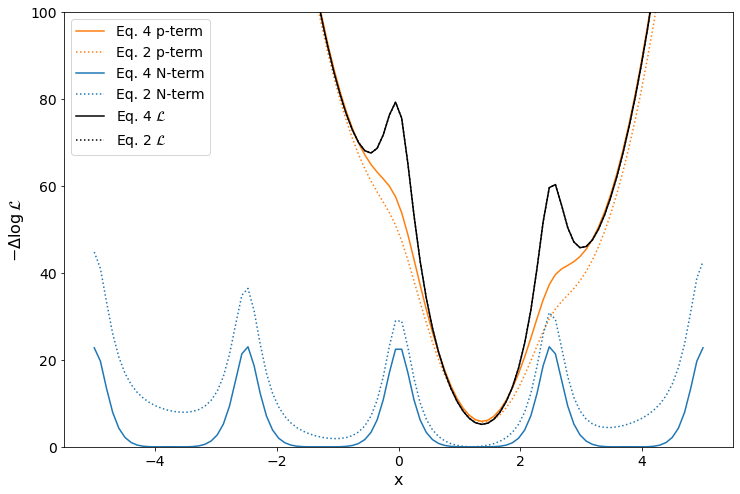

In [113]:
s = g[:,0.3]
#s = g[1.45]

fig, ax = plt.subplots(1,1, figsize=(12,8))

c2 = 'tab:blue'
c1 = 'tab:orange'
c3 = 'k' #tab:green'



s.total_charge_hit_terms.plot(c=c1, ls='-', label="Eq. 4 p-term")
s.dom_hit_term.plot(c=c1, ls=':', label="Eq. 2 p-term")

s.total_charge_terms.plot(c=c2, ls='-', label="Eq. 4 N-term")
s.dom_charge_terms.plot(c=c2, ls=':', label="Eq. 2 N-term")

s.total_charge_llh.plot(c=c3, ls='-', label=r"Eq. 4 $\mathcal{L}$")
s.dom_llh.plot(c=c3, ls=':', label=r"Eq. 2 $\mathcal{L}$")



plt.legend()

ax.set_ylabel(r'$-\Delta\log{\mathcal{L}}$')

plt.gca().set_ylim(0, 100)